In [38]:
import numpy as np
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

arr = np.load("logits_class_raw")

arr = arr.reshape(-1, 1024)

arr = torch.from_numpy(arr)

arr = F.sigmoid(arr).round().float()

ans = np.zeros(shape=(arr.shape[0],))

for i, sample in enumerate(arr):
    idx = sample.nonzero()[0]
    ans[i] = idx

np.save("logits_class.npy", ans)

(4998,)


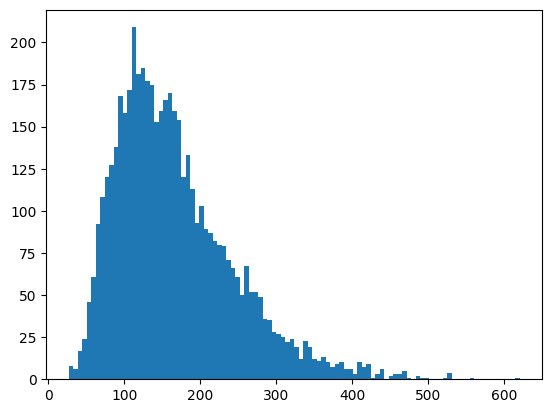

In [36]:
import matplotlib.pyplot as plt
arr = np.load("logits_regr_old.npy")
print(arr.shape)
plt.hist(arr, bins = 100)
plt.show()

In [26]:
arr = np.load("bert_reg.npy")
arr

array([150., 300.,  98., ..., 133., 316., 155.])